
# 🎰 The Casino Challenge — Multi‑Armed Bandits & ε‑Greedy (Gamified Workshop)

**Goal:** Compete to maximize reward while learning the exploration–exploitation trade‑off using **ε‑greedy** policies.

**You will:**
- Implement and *play* with ε‑greedy on a fixed set of bandit arms (Round 1: Stationary).
- Compete on a leaderboard (submit your score locally).
- Reflect on how exploration affects performance.
- Face a twist (Round 2: **Non‑Stationary** bandits) and adapt your strategy.



## 🔧 Setup

Run the cell below. If you're on Colab/Jupyter, required libraries should already be available.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import time
from pathlib import Path
from datetime import datetime

plt.rcParams['figure.figsize'] = (8, 4)

print("Numpy:", np.__version__)
print("Matplotlib:", plt.matplotlib.__version__)


Numpy: 1.26.4
Matplotlib: 3.10.3


In [2]:

def plot_cumulative(rewards, title="Cumulative Reward"):
    plt.figure()
    plt.plot(np.cumsum(rewards))
    plt.title(title)
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.show()



## 🎲 Environment: Stationary Bernoulli Bandits

Ten arms, each with a hidden probability of reward. You won't see the true means during play, but we print them here for **instructor debugging/analysis**. You may comment this out during the competition.


In [3]:

def make_stationary_bandit(n_arms=10, seed=42):
    rng = np.random.default_rng(seed)
    true_means = rng.random(n_arms)  # in [0,1)
    return true_means

# Instructor may reveal (comment out in live competition to keep secret)
SEED_ENV = 42  # 🔒 Keep this fixed across all students for fairness (Round 1)
TRUE_MEANS = make_stationary_bandit(seed=SEED_ENV)
print("DEBUG — True means (hidden in competition):", np.round(TRUE_MEANS, 3))


DEBUG — True means (hidden in competition): [0.774 0.439 0.859 0.697 0.094 0.976 0.761 0.786 0.128 0.45 ]



## 🤖 Agent: ε‑Greedy (Fixed or Decaying)

- With probability **ε**, explore a random arm.
- Otherwise, exploit the best arm found so far (highest estimated value).
- Estimates updated via **incremental sample average**.


In [4]:

def epsilon_greedy(true_means, steps=1000, epsilon=0.1, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)     # value estimates
    N = np.zeros(n_arms)     # counts
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]  # incremental mean
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N

def epsilon_greedy_decaying(true_means, steps=1000, eps_start=0.5, eps_end=0.05, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)
    N = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # Linear decay
        epsilon = eps_end + (eps_start - eps_end) * max(0, (steps - 1 - t)) / max(1, steps - 1)
        if rng.random() < epsilon:
            a = rng.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
        actions[t] = a
    return rewards, actions, Q, N



# 🏁 Round 1 — Stationary Casino (Competition)

**Instructions**
1. Set your **NAME** and **STRATEGY**.
2. Choose **steps** and **ε** (or decaying ε parameters).
3. Run the simulation cell.
4. Submit to the local leaderboard (next cell).

> Everyone must use the same **SEED_ENV** to ensure the environment is identical. You can set your **agent seed** for reproducibility.



Player: Your Name
Strategy: epsilon_greedy_decaying (decay_eps=0.5->0.05)
Steps: 2000
Total Reward: 1724
Estimated Best Arm: 5
Estimated Q: [0.791 0.4   0.86  0.639 0.019 0.975 0.8   0.849 0.137 0.35 ]
Counts N: [  67   65   86   61   52 1450   55   53   51   60]



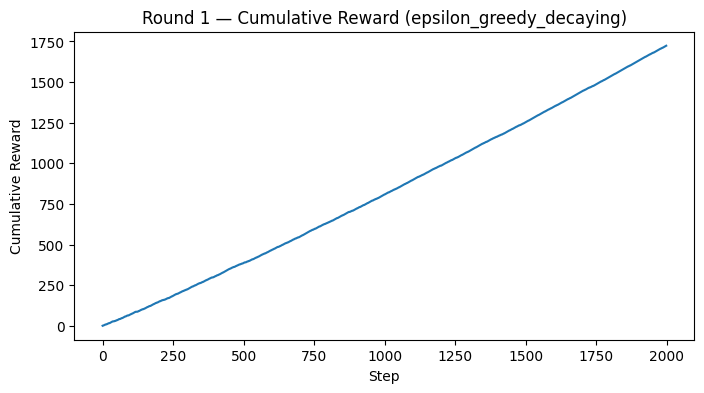

In [8]:

# === YOUR SETTINGS (edit) ===
NAME = "Your Name"
STRATEGY = "epsilon_greedy_decaying"  # options: "epsilon_greedy" or "epsilon_greedy_decaying"
STEPS = 2000

# For fixed ε
EPSILON = 0.1

# For decaying ε
EPS_START = 0.5
EPS_END = 0.05

# Agent RNG seed (can be None for randomness)
SEED_AGENT = 123

# === RUN ===
if STRATEGY == "epsilon_greedy":
    rewards, actions, Q, N = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=EPSILON, seed=SEED_AGENT)
    strat_desc = f"fixed_eps={EPSILON}"
elif STRATEGY == "epsilon_greedy_decaying":
    rewards, actions, Q, N = epsilon_greedy_decaying(TRUE_MEANS, steps=STEPS, eps_start=EPS_START, eps_end=EPS_END, seed=SEED_AGENT)
    strat_desc = f"decay_eps={EPS_START}->{EPS_END}"
else:
    raise ValueError("Unknown STRATEGY setting")

total = float(np.sum(rewards))
best_arm_est = int(np.argmax(Q))
print(f"""
Player: {NAME}
Strategy: {STRATEGY} ({strat_desc})
Steps: {STEPS}
Total Reward: {total:.0f}
Estimated Best Arm: {best_arm_est}
Estimated Q: {np.round(Q,3)}
Counts N: {N.astype(int)}
""")
plot_cumulative(rewards, title=f"Round 1 — Cumulative Reward ({STRATEGY})")



### 🧮 Submit to Leaderboard (Round 1)

This writes your result to a local CSV (`submissions_round1.csv`) in the current folder.  
The instructor can collect these files or run the next cell to view a local leaderboard.


In [9]:

import csv

lb_path = Path("submissions_round1.csv")
lb_exists = lb_path.exists()

row = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME,
    "strategy": STRATEGY,
    "details": strat_desc,
    "steps": STEPS,
    "seed_env": SEED_ENV,
    "seed_agent": SEED_AGENT,
    "total_reward": int(np.sum(rewards))
}

fieldnames = ["timestamp","name","strategy","details","steps","seed_env","seed_agent","total_reward"]

with open(lb_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    if not lb_exists:
        writer.writeheader()
    writer.writerow(row)

print("Submitted to", lb_path.resolve())


Submitted to /Users/hsi/1557code/RLP/MultiArmedBandit_Workshop/submissions_round1.csv


/var/folders/5f/yqkj_zgn7qzcqxxmhxl7rk9c0000gn/T/ipykernel_17415/2191877043.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


In [10]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round1.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,details,steps,seed_env,seed_agent,total_reward
0,2025-10-17T22:05:57.691026,Your Name,epsilon_greedy,fixed_eps=0.1,2000,42,123,1862
1,2025-10-17T22:08:41.643216,Your Name,epsilon_greedy_decaying,decay_eps=0.5->0.05,2000,42,123,1724



## 🧠 Step 6 — Reflect & Discuss (for your notes / debrief)

1. **What strategy did you use and why?** 

    A: I used the ε-greedy strategy—both fixed (ε=0.1) and decaying ε. It balances exploration and exploitation, which helps maximize reward when true values are unknown. 

2. **How did ε influence your total reward?** Did you try multiple ε values?

    A: A lower fixed ε (0.1) resulted in a higher total reward (1862) compared to the higher/decaying ε case (reward: 1724). I tried both fixed and decaying schedules; smaller ε enabled more exploitation after initial exploration.

3. **Did your agent get “stuck” exploiting too soon?** How could you prevent that?

    A: With a small fixed ε, the agent risked premature exploitation. Using a decaying or variable ε, or scheduling periodic increases in ε, could prevent getting stuck and encourage continued exploration.

4. **If you had more steps, what would you change (ε schedule, update rule, etc.)?**

    A: For a longer horizon, I’d use a slower ε decay or keep ε higher for longer, ensuring more exploration, and possibly adopt a constant step-size (α) for faster adaptation.

5. **Compare with others:** Did randomness or design matter more for the winners?

    A: Design (strategy choice and parameter tuning) mattered more. While randomness affects outcomes in the short term, well-chosen ε schedules consistently outperform random choices.

6. **Transfer:** Where would this exploration dilemma appear in real systems (recsys, A/B testing, ads)?

    A: This dilemma is common in recommender systems, A/B testing, and online advertising—any setting balancing trying new options (to learn more) versus showing the best-known choice (to maximize utility).


## 📊 Experiment: Compare Different ε Values (Optional)

Run multiple ε settings to *see* the exploration trade‑off.


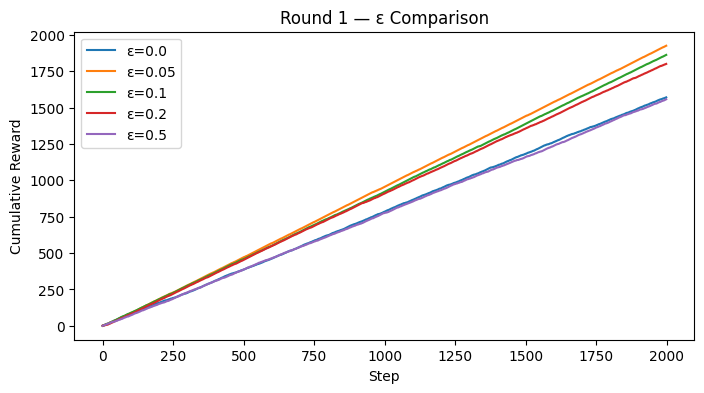

In [11]:

eps_list = [0.0, 0.05, 0.1, 0.2, 0.5]
curves = {}
for eps in eps_list:
    r, _, _, _ = epsilon_greedy(TRUE_MEANS, steps=STEPS, epsilon=eps, seed=SEED_AGENT)
    curves[eps] = np.cumsum(r)

plt.figure()
for eps, curve in curves.items():
    plt.plot(curve, label=f"ε={eps}")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Round 1 — ε Comparison")
plt.show()


**Analysis:**

The plot compares the **cumulative reward** over time (**Step**) for the **$\epsilon$-greedy algorithm** using various values of the exploration parameter **$\epsilon$** ($\epsilon = 0.0, 0.05, 0.1, 0.2, 0.5$).

1.  **Optimal Performance:** The curves for **$\epsilon = 0.05$, $0.1$, and $0.2$** achieve the highest cumulative reward, suggesting that a small amount of exploration leads to better long-term performance (higher reward) compared to pure exploitation ($\epsilon=0.0$).
2.  **Pure Exploitation ($\epsilon=0.0$):** The pure greedy strategy ($\epsilon=0.0$) performs the worst alongside $\epsilon=0.5$. This indicates that without any exploration, the agent likely got stuck in a suboptimal choice early on.
3.  **High Exploration ($\epsilon=0.5$):** The strategy with the highest exploration ($\epsilon=0.5$) also performs poorly (similar to $\epsilon=0.0$), suggesting that excessive random action (exploration) prevents the agent from adequately exploiting the best actions.
4.  **Conclusion:** The results demonstrate the classic **exploration-exploitation trade-off**. A small, non-zero $\epsilon$ (e.g., $0.05$ to $0.2$) is necessary to discover the optimal action, leading to the highest cumulative reward.


# 🔄 Round 2 — Non‑Stationary Casino (Competition)

**Twist:** The slot machines drift over time. Fixed exploitation can fail; adaptive exploration helps.

Two common adaptations:
- Keep **ε** from decaying too low (retain exploration).
- Use a **constant step size α** (exponential moving average) to weight recent rewards more.


In [12]:

def nonstationary_means(n_arms=10, seed=2025):
    # Initialize random means
    rng = np.random.default_rng(seed)
    return rng.random(n_arms)

def step_drift(means, drift_scale=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    means = means + rng.normal(0, drift_scale, size=means.shape)
    return np.clip(means, 0.0, 1.0)

def epsilon_greedy_constant_alpha(steps=2000, n_arms=10, eps=0.1, alpha=0.1, seed_env=7, seed_agent=None, drift_scale=0.01):
    # Non-stationary env with drifting means
    rng_env = np.random.default_rng(seed_env)
    rng_agent = np.random.default_rng(seed_agent)
    means = rng_env.random(n_arms)
    Q = np.zeros(n_arms)
    rewards = np.zeros(steps, dtype=float)
    actions = np.zeros(steps, dtype=int)
    for t in range(steps):
        # choose action
        if rng_agent.random() < eps:
            a = rng_agent.integers(0, n_arms)
        else:
            a = int(np.argmax(Q))
        # reward from current means
        r = 1.0 if rng_env.random() < means[a] else 0.0
        # constant step-size update (EMA)
        Q[a] = Q[a] + alpha * (r - Q[a])
        rewards[t] = r
        actions[t] = a
        # drift environment
        means = step_drift(means, drift_scale=drift_scale, rng=rng_env)
    return rewards, actions, Q



[Round 2]
Player: Your Name
Strategy: epsilon_greedy + constant_alpha (eps=0.1, alpha=0.1)
Steps: 3000
Total Reward: 2557



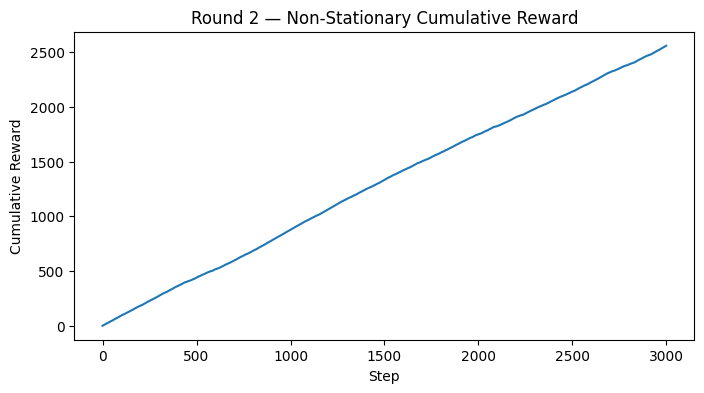

In [13]:

# === YOUR SETTINGS (edit) ===
NAME_R2 = "Your Name"
STEPS_R2 = 3000
EPS_R2 = 0.1     # keep some exploration alive
ALPHA_R2 = 0.1   # constant step size for non-stationarity
SEED_ENV_R2 = 2025  # shared across class
SEED_AGENT_R2 = 999
DRIFT_SCALE = 0.01  # magnitude of mean drift per step

# === RUN ===
rewards_r2, actions_r2, Q_r2 = epsilon_greedy_constant_alpha(
    steps=STEPS_R2, n_arms=10, eps=EPS_R2, alpha=ALPHA_R2,
    seed_env=SEED_ENV_R2, seed_agent=SEED_AGENT_R2, drift_scale=DRIFT_SCALE
)

total_r2 = int(np.sum(rewards_r2))
print(f"""
[Round 2]
Player: {NAME_R2}
Strategy: epsilon_greedy + constant_alpha (eps={EPS_R2}, alpha={ALPHA_R2})
Steps: {STEPS_R2}
Total Reward: {total_r2}
""")
plot_cumulative(rewards_r2, title="Round 2 — Non‑Stationary Cumulative Reward")


**Analysis:**

The plot displays the **cumulative reward** achieved by the agent over **$3000$ Steps** in a **non-stationary** multi-armed bandit environment.

1.  **Non-Stationary Adaptation:** The $\epsilon$-greedy algorithm is adapted for the non-stationary environment using a **constant step-size parameter ($\alpha = 0.1$)** for updating the action values ($Q$). This approach, often called an **Exponential Moving Average (EMA)**, gives more weight to recent rewards and effectively **"forgets"** old, less relevant reward history, allowing the agent to track the **drifting optimal arm**.
2.  **Performance:** The cumulative reward curve exhibits a **near-linear growth** over the $3000$ steps.
3.  **Conclusion:** The linear trend indicates the agent successfully adapted to the $\mathbf{0.01}$ **drift in the means** and consistently selected near-optimal or optimal actions. The combination of **constant exploration ($\epsilon = 0.1$)** to re-discover the best arm and the **constant step-size ($\alpha = 0.1$)** for fast adaptation is an effective strategy for this non-stationary task, leading to a high, steady rate of reward accumulation.

In [14]:

import csv
lb2_path = Path("submissions_round2.csv")
lb2_exists = lb2_path.exists()

row2 = {
    "timestamp": datetime.utcnow().isoformat(),
    "name": NAME_R2,
    "strategy": f"eps={EPS_R2}, alpha={ALPHA_R2}",
    "steps": STEPS_R2,
    "seed_env": SEED_ENV_R2,
    "seed_agent": SEED_AGENT_R2,
    "drift_scale": DRIFT_SCALE,
    "total_reward": total_r2
}

fieldnames2 = ["timestamp","name","strategy","steps","seed_env","seed_agent","drift_scale","total_reward"]

with open(lb2_path, "a", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=fieldnames2)
    if not lb2_exists:
        writer.writeheader()
    writer.writerow(row2)

print("Submitted to", lb2_path.resolve())


Submitted to /Users/hsi/1557code/RLP/MultiArmedBandit_Workshop/submissions_round2.csv


/var/folders/5f/yqkj_zgn7qzcqxxmhxl7rk9c0000gn/T/ipykernel_17415/2415904048.py:6: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  "timestamp": datetime.utcnow().isoformat(),


In [15]:
import pandas as pd
from IPython.display import display

lb_path = Path("submissions_round2.csv")

if lb_path.exists():
    df = pd.read_csv(lb_path)
    df_sorted = df.sort_values("total_reward", ascending=False).reset_index(drop=True)
    print("🏆 Round 1 Leaderboard (sorted by total reward):")
    display(df_sorted)
else:
    print("No submissions yet. Run the previous cell to submit your score.")


🏆 Round 1 Leaderboard (sorted by total reward):


,timestamp,name,strategy,steps,seed_env,seed_agent,drift_scale,total_reward
0,2025-10-17T22:26:41.390587,Your Name,"eps=0.1, alpha=0.1",3000,2025,999,0.01,2557



## 🧪 Bonus (Optional): Compete with UCB or Thompson Sampling

If allowed by the instructor, try implementing:
- **UCB1 (Upper Confidence Bound):** add an optimism bonus to less‑tried arms.
- **Thompson Sampling:** maintain Beta posteriors for each arm and sample to choose.

> Keep Round 1/2 seeds the same for comparability.


**UCB1 (Upper Confidence Bound)** and **Thompson Sampling** are both classic multi-armed bandit exploration strategies:

**UCB1 (Upper Confidence Bound) Algorithm**
- Purpose: Automatically balance exploration and exploitation.
- Concept: For each arm (option), in addition to considering the current estimated reward, an "optimism bonus" is added to give arms with fewer attempts a chance to be selected more often.
- Algorithm Formula:

    $Q_t(a) + c \sqrt{ \frac{\ln t}{N_t(a)} }$

    Where $Q_t(a)$ is the average reward of arm $a$, $N_t(a)$ is the number of selections, $t$ is the current step number, and $c$ is a hyperparameter.
- Core approach: "Good estimate + uncertainty": select the arm with the maximum value at each step.

**Thompson Sampling (Bayesian Sampling) Algorithm**
- Purpose: Use the Bayesian probability model to naturally implement exploration and exploitation.
- Concept: Maintain a set of probability distribution parameters (e.g., a Beta distribution) for each arm, and use sample values ​​to determine which arm to choose next.
- Process:

    1. Use Beta(α, β) (win/lose statistic) to represent the "belief" about the probability of a prize in each arm.

    2. Each round, draw a value from the Beta distribution for each arm and try the arm with the largest sample.

    3. Update the win/lose parameters based on the trial results.
- Features: The exploration ratio automatically adjusts based on the "belief uncertainty," with the greater the uncertainty, the more attempts are made.

**Key Differences Between the Two**
- UCB1 calculates a clear optimistic upper bound, directly calculated at each step.
- Thompson Sampling "let probability speak for itself," using random sampling to balance the arms with high confidence and those with uncertainty.
- UCB1 is more frequentist, Thompson is more Bayesian.

**Application**: Both are suitable for scenarios such as recommendation systems and experimental A/B testing, allowing decisions to achieve the best trade-off between future rewards and new knowledge learning.

**Implement UCB1(Upper Confidence Bound) Algorithm**
   - For each arm, keep counts $N_t(a)$ and average rewards $Q_t(a)$.
   - At each step, select arm $a$ maximizing:
     $Q_t(a) + c \cdot \sqrt{\frac{\ln t}{N_t(a)}}$
     where $c$ is a tunable 'optimism' parameter (e.g., 2).
   - After each pull, update both $Q_t(a)$ and $N_t(a)$.

**Implement Thompson Sampling**
   - For each arm, maintain Beta distribution parameters ($\alpha, \beta$), initialize as ($\alpha=1, \beta=1$).
   - At each step, for every arm, sample reward probability from Beta($\alpha, \beta$), pick arm with highest sample.
   - Update Beta parameters after each play: increment $\alpha$ for win, $\beta$ for loss.

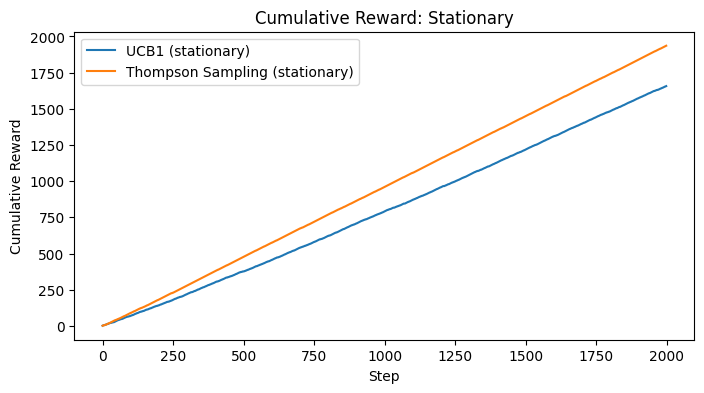

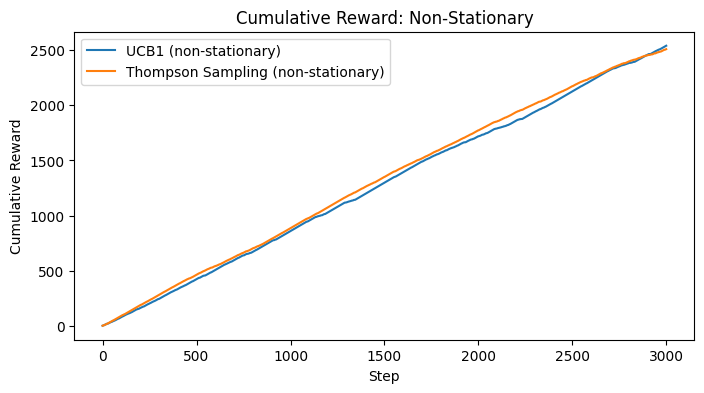

Total reward - UCB1 (stationary): 1657
Total reward - Thompson Sampling (stationary): 1936
Total reward - UCB1 (non-stationary): 2540
Total reward - Thompson Sampling (non-stationary): 2509


In [20]:
import numpy as np
import matplotlib.pyplot as plt

##############
# Stationary
##############

# UCB1 Stationary
def ucb1_stationary(true_means, steps=2000, c=2, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    Q = np.zeros(n_arms)
    N = np.zeros(n_arms)
    rewards = np.zeros(steps)
    for t in range(steps):
        if 0 in N:
            a = np.argmin(N)
        else:
            ucb = Q + c * np.sqrt(np.log(t+1) / (N+1e-8))
            a = np.argmax(ucb)
        r = 1.0 if rng.random() < true_means[a] else 0.0
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]
        rewards[t] = r
    return rewards

# Thompson Sampling Stationary (Bernoulli)
def thompson_stationary(true_means, steps=2000, seed=None):
    rng = np.random.default_rng(seed)
    n_arms = len(true_means)
    alpha = np.ones(n_arms)
    beta = np.ones(n_arms)
    rewards = np.zeros(steps)
    for t in range(steps):
        samples = rng.beta(alpha, beta)
        a = np.argmax(samples)
        r = 1.0 if rng.random() < true_means[a] else 0.0
        if r == 1:
            alpha[a] += 1
        else:
            beta[a] += 1
        rewards[t] = r
    return rewards

##############
# Non-Stationary
##############

def step_drift(means, drift_scale=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    means = means + rng.normal(0, drift_scale, size=means.shape)
    return np.clip(means, 0.0, 1.0)

# UCB1 for Non-Stationary (constant alpha)
def ucb1_nonstationary(n_arms, steps, c=2, seed_env=None, seed_agent=None, drift_scale=0.01, alpha=0.1):
    rng_env = np.random.default_rng(seed_env)
    rng_agent = np.random.default_rng(seed_agent)
    means = rng_env.random(n_arms)
    Q = np.zeros(n_arms)
    N = np.zeros(n_arms)
    rewards = np.zeros(steps)
    for t in range(steps):
        if 0 in N:
            a = np.argmin(N)
        else:
            ucb = Q + c * np.sqrt(np.log(t+1) / (N+1e-8))
            a = np.argmax(ucb)
        r = 1.0 if rng_env.random() < means[a] else 0.0
        N[a] += 1
        Q[a] += alpha * (r - Q[a])
        rewards[t] = r
        means = step_drift(means, drift_scale, rng_env)
    return rewards

# Thompson Sampling Non-Stationary (constant alpha for value tracking)
def thompson_nonstationary(n_arms, steps, seed_env=None, seed_agent=None, drift_scale=0.01, alpha=0.1):
    rng_env = np.random.default_rng(seed_env)
    rng_agent = np.random.default_rng(seed_agent)
    means = rng_env.random(n_arms)
    Q = np.zeros(n_arms)
    alpha_p = np.ones(n_arms)
    beta_p = np.ones(n_arms)
    rewards = np.zeros(steps)
    for t in range(steps):
        samples = rng_agent.beta(alpha_p, beta_p)
        a = np.argmax(samples)
        r = 1.0 if rng_env.random() < means[a] else 0.0
        Q[a] += alpha * (r - Q[a])  # value tracking (optional plotting)
        if r == 1:
            alpha_p[a] += 1
        else:
            beta_p[a] += 1
        rewards[t] = r
        means = step_drift(means, drift_scale, rng_env)
    return rewards

##################
# Plotting utility
##################
def plot_cumulative_rewards(curves, labels, title):
    plt.figure(figsize=(8,4))
    for curve, label in zip(curves, labels):
        plt.plot(np.cumsum(curve), label=label)
    plt.xlabel("Step")
    plt.ylabel("Cumulative Reward")
    plt.title(title)
    plt.legend()
    plt.show()

##########
# Example Driver
##########

# Stationary settings
SEED_ENV = 42
SEED_AGENT = 123
TRUE_MEANS = np.array([0.774, 0.439, 0.859, 0.697, 0.094, 0.976, 0.761, 0.786, 0.128, 0.45])
STEPS = 2000

rewards_ucb_stationary = ucb1_stationary(TRUE_MEANS, steps=STEPS, c=2, seed=SEED_AGENT)
rewards_ts_stationary = thompson_stationary(TRUE_MEANS, steps=STEPS, seed=SEED_AGENT)

plot_cumulative_rewards([rewards_ucb_stationary, rewards_ts_stationary],
    ["UCB1 (stationary)", "Thompson Sampling (stationary)"], "Cumulative Reward: Stationary")

# Non-stationary settings
N_ARMS = 10
STEPS_NON = 3000
SEED_ENV_R2 = 2025
SEED_AGENT_R2 = 999
DRIFT_SCALE = 0.01
ALPHA = 0.1

rewards_ucb_non = ucb1_nonstationary(N_ARMS, STEPS_NON, c=2, seed_env=SEED_ENV_R2, seed_agent=SEED_AGENT_R2, drift_scale=DRIFT_SCALE, alpha=ALPHA)
rewards_ts_non = thompson_nonstationary(N_ARMS, STEPS_NON, seed_env=SEED_ENV_R2, seed_agent=SEED_AGENT_R2, drift_scale=DRIFT_SCALE, alpha=ALPHA)

plot_cumulative_rewards([rewards_ucb_non, rewards_ts_non],
    ["UCB1 (non-stationary)", "Thompson Sampling (non-stationary)"], "Cumulative Reward: Non-Stationary")

print("Total reward - UCB1 (stationary):", int(np.sum(rewards_ucb_stationary)))
print("Total reward - Thompson Sampling (stationary):", int(np.sum(rewards_ts_stationary)))
print("Total reward - UCB1 (non-stationary):", int(np.sum(rewards_ucb_non)))
print("Total reward - Thompson Sampling (non-stationary):", int(np.sum(rewards_ts_non)))



---

### ✅ Submission Notes for Instructors
- Each student’s notebook writes a local CSV (`submissions_round1.csv` / `submissions_round2.csv`).  
  Collect these files or ask students to paste rows into a shared sheet for a class-wide leaderboard.
- **Fairness:** Keep `SEED_ENV` (Round 1) and `SEED_ENV_R2` (Round 2) fixed across all students.
- **Assessment Ideas:** Award badges like *Risk Taker* (highest ε with solid score), *Efficient Exploiter*, *Adaptive Strategist* (best in Round 2).

### 🧠 Learning Outcomes
- Understand & visualize the exploration–exploitation trade‑off.
- See why ε matters, and why **constant‑α** helps in non‑stationary settings.
- Practice experimental design (controlled seeds, fair comparisons, parameter sweeps).

Happy bandit hunting! 🎲


---

# MultiArmedBandit_Workshop

**Summary of Logic:**
- For each step, decide whether to explore (try a random arm) or exploit (pick the arm that currently seems best).
- Pull the chosen arm and get a reward (either 0 or 1).
- Update the estimates for the arm's expected reward based on experience.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulate the environment
np.random.seed(42)

n_arms = 10  # Number of slot machines
true_means = np.random.rand(n_arms)  # True (hidden) reward probabilities for each arm

print("True means (hidden):", np.round(true_means, 3))


True means (hidden): [0.375 0.951 0.732 0.599 0.156 0.156 0.058 0.866 0.601 0.708]


**Definitions:** 
- **Step:**  
  - Each iteration of the loop (for t in range(steps)) is a "step".  
  - Every step represents a single decision point where the agent must choose which slot machine (arm) to pull.

- **Action:**  
  - The "action" is the index of the arm selected on that step.  
  - It is chosen either randomly (exploration, with probability epsilon) or by picking the arm with the highest estimated reward (exploitation).

- **Reward:**  
  - After choosing an action, the code simulates the result by generating a random number — if it's less than the arm's true mean, the agent receives a reward (value 1); otherwise, no reward (value 0).
  - This reward is added to the rewards list and used to update the estimated value for that arm.

In [2]:
def epsilon_greedy_bandit(true_means, epsilon=0.1, steps=1000):
    n_arms = len(true_means)
    Q = np.zeros(n_arms)   # Estimated value of each arm
    N = np.zeros(n_arms)   # Number of times each arm was chosen
    rewards = []

    for t in range(steps):
        # Decide whether to explore or exploit
        if np.random.rand() < epsilon:
            action = np.random.randint(n_arms)  # Explore
        else:
            action = np.argmax(Q)  # Exploit

        # Generate reward from the chosen arm
        reward = np.random.rand() < true_means[action]

        # Update estimates (incremental average)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        rewards.append(reward)

    return np.array(rewards), Q


In [3]:
rewards, Q = epsilon_greedy_bandit(true_means, epsilon=0.1, steps=1000)

print("Estimated means:", np.round(Q, 3))
print("Best arm chosen:", np.argmax(Q))
print("Total reward:", np.sum(rewards))


Estimated means: [0.462 0.945 0.923 0.636 0.143 0.091 0.125 0.895 0.5   0.692]
Best arm chosen: 1
Total reward: 903


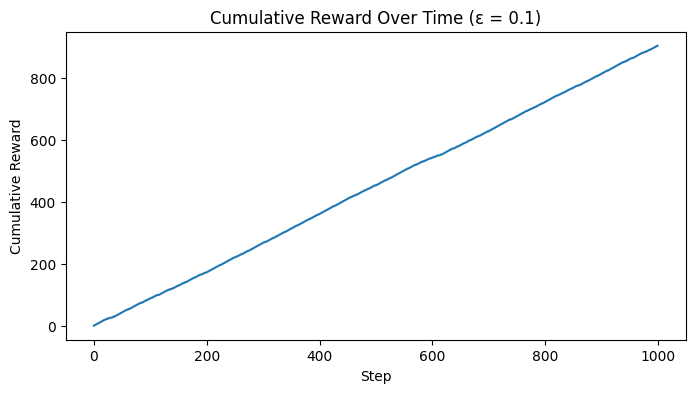

In [4]:
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(rewards))
plt.title("Cumulative Reward Over Time (ε = 0.1)")
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.show()


- Epsilon 0.1 yields steady reward gains — exploration ensures near-linear cumulative improvement across steps.

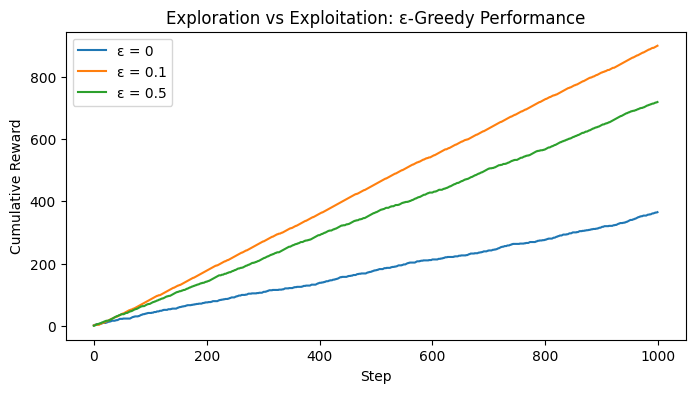

In [5]:
epsilons = [0, 0.1, 0.5]
steps = 1000
results = {}

for eps in epsilons:
    rewards, _ = epsilon_greedy_bandit(true_means, epsilon=eps, steps=steps)
    results[eps] = np.cumsum(rewards)

plt.figure(figsize=(8, 4))
for eps, rewards in results.items():
    plt.plot(rewards, label=f"ε = {eps}")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Cumulative Reward")
plt.title("Exploration vs Exploitation: ε-Greedy Performance")
plt.show()


- Higher epsilon enhances learning: ε = 0.1 gives best long-term reward, balancing exploration and exploitation.